Sheet 2.3: Non-linear regression (MLP w/ PyTorch modules)
=========================================================

**Author:** Michael Franke



In this tutorial, we will fit a non-linear regression, implemented as a multi-layer perceptron.
We will see how the use of modules from PyTorch&rsquo;s neural network package \`torch.nn\` helps us implement the model efficiently.



## Packages & global parameters



We will need to import the `torch` package for the main functionality.
In addition to the previous sheet, In order to have a convenient, we will use PyTorch&rsquo;s `DataLoader` and `Dataset` in order to feed our training data to the model.



In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## True model & training data



The &ldquo;true model&rdquo; is a constructed non-linear function $y = f(x)$.
Here is its definition and a plot to show what the &ldquo;ground truth&rdquo; looks like.



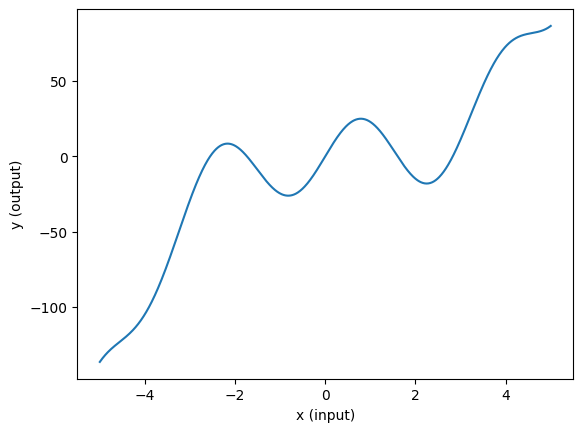

In [2]:
##################################################
## ground-truth model
##################################################


def goal_fun(x):
    """
    This is a non-linear function that is the "ground truth" for this example.
    """
    return x**3 - x**2 + 25 * np.sin(2 * x)


# create linear sequence (x) and apply goal_fun(y)
x = np.linspace(start=-5, stop=5, num=1000)
y = goal_fun(x)

# plot the function
d = pd.DataFrame({"x (input)": x, "y (output)": y})
sns.lineplot(data=d, x="x (input)", y="y (output)")
plt.show()

The training data consists of 100 pairs of  $(x,y)$ values.
Each pair is generated by first sampling an $x$ value from a uniform distribution.
For each sampled $x$, we compute the value of the target function $f(x)$ and add Gaussian noise to it.



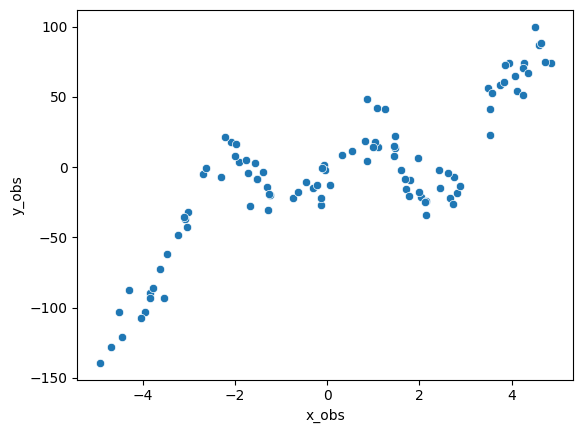

In [3]:
##################################################
## generate training data (with noise)
##################################################

n_obs = 100  # number of observations

# get noise around y observations
y_normal = torch.distributions.Normal(loc=0.0, scale=10)
y_noise = y_normal.sample([n_obs])

# get observations
x_obs = 10 * torch.rand([n_obs]) - 5  # uniform from [-5,5]
y_obs = goal_fun(x_obs) + y_noise

# plot the data
d = pd.DataFrame({"x_obs": x_obs, "y_obs": y_obs})
sns.scatterplot(data=d, x="x_obs", y="y_obs")
plt.show()

## Defining the MLP using PyTorch&rsquo;s built-in modules



Our model maps a single scalar $x$ onto another scalar $y$.
We use a 3-layer MLP, each hidden layer with dimension 10:



In [4]:
##################################################
## network dimension parameters
##################################################

n_input = 1
n_hidden = 10
n_output = 1

PyTorch defines a special-purpose class called `nn.Module` from which pre-defined neural networks or custom-made networks inherit the structure and basic functionality.
Below, we define our feed-forward neural network as a class extending `nn.Module`.
Minimally, we have to define two functions for this to work:

1.  the **initialization** function `__init__` which defines which variables (mostly, but not exclusively: parameters) our model has (using `nn.Linear` instantiates a linear layer with all the trainable parameters (weights and biases) implicitly);
2.  the **forward pass** which takes the model&rsquo;s input and computes the corresponding prediction given the current parameter values. Instatiating the forward pass is critical because it is designed to also implicitly compute and save gradients of single computations that constitute the neural network with respect to the current input, so that they can be later used for the **backward pass** (i.e., for training).

Since PyTorch allows flexibility in how to define neural network modules, we look at two variants below, one explicit and one more concise.
They should implement the exact same model and work the same way eventually.

### More explicit definition NN module



In [5]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- explicit version --
##################################################


class MLPexplicit(nn.Module):
    """
    Multi-layer perceptron for non-linear regression.
    """

    def __init__(self, n_input, n_hidden, n_output):
        super(MLPexplicit, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.linear1 = nn.Linear(self.n_input, self.n_hidden)
        self.linear2 = nn.Linear(self.n_hidden, self.n_hidden)
        self.linear3 = nn.Linear(self.n_hidden, self.n_hidden)
        self.linear4 = nn.Linear(self.n_hidden, self.n_output)
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.linear1(x))
        h2 = self.relu(self.linear2(h1))
        h3 = self.relu(self.linear3(h2))
        output = self.linear4(h3)
        return output


mlp_explicit = MLPexplicit(n_input, n_hidden, n_output)

We can access the current parameter values of this model instance like so:



In [6]:
for param in mlp_explicit.parameters():
    print(param.detach().numpy().round(4))

[[-0.7675]
 [ 0.3062]
 [-0.7604]
 [-0.4253]
 [ 0.8196]
 [-0.5166]
 [ 0.3552]
 [ 0.4813]
 [-0.6652]
 [ 0.8185]]
[ 0.3823  0.4706  0.5486  0.6039  0.4609  0.2709 -0.2047  0.925  -0.6833
  0.1818]
[[-0.301   0.21   -0.093  -0.0282  0.0829 -0.0377 -0.1405 -0.0393  0.2266
  -0.2164]
 [ 0.2661  0.2816 -0.207  -0.0577 -0.2861 -0.2977  0.3031 -0.2893  0.1461
   0.0053]
 [-0.2834 -0.2353 -0.2257 -0.2188 -0.1738  0.1292  0.252   0.1853  0.1001
  -0.0274]
 [ 0.1619  0.1165  0.2062  0.0104  0.1162 -0.0438  0.0648  0.2143  0.0038
   0.1657]
 [-0.1317 -0.0425  0.1764 -0.1712  0.2999 -0.3024  0.1071  0.2976  0.0162
   0.1403]
 [-0.0209 -0.2958  0.0659  0.2485  0.1547  0.1934  0.1127 -0.0615  0.3054
   0.0274]
 [-0.024  -0.0729  0.1347  0.2176  0.0086 -0.0286 -0.0289  0.1842 -0.3011
  -0.135 ]
 [ 0.1377  0.0041 -0.2119  0.1757  0.1169 -0.3065 -0.3053  0.2597 -0.1552
   0.29  ]
 [ 0.1738 -0.0464  0.2393  0.1009 -0.3136  0.0821 -0.0785  0.0833 -0.0199
   0.2284]
 [ 0.1001 -0.0329 -0.2284  0.089  -0.2605

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.3.1: Inspect the model&rsquo;s parameters and their initial values</span></strong>
>
> 0. Make sure that you understand what these parameters are. (Hint: We have a 3 layer network, each hidden layer has 10 nodes. We should expect to see slopes (aka weights) and intercepts (biases) somewhere. The order of the presentation in this print-out is the order in which the numbers matter in the computation of the forward pass.)
>
> 1. Guess how the weights of the slope matrices are initialized (roughly). Same for the intercept vectors.

### More concise definition of NN module



Here is another, more condensed definition of the same NN model, which uses the `nn.Sequential` function to neatly chain components, thus defining the model parameters and the forward pass in one swoop.



In [ ]:
##################################################
## set up multi-layer perceptron w/ PyTorch
##    -- condensed version --
##################################################


class MLPcondensed(nn.Module):
    """
    Multi-layer perceptron for non-linear regression.
    """

    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output),
        )

    def forward(self, x):
        return self.layers(x)


mlp_condensed = MLPcondensed(n_input, n_hidden, n_output)

Here you can select which of the two models to use in the following.



In [ ]:
# which model to use from here onwards
# model = mlpExplicit
model = mlp_condensed

## Preparing the training data



Data pre-processing is a tedious job, but an integral part of machine learning.
In order to have a clean interface between data processing and modeling, we would ideally like to have a common data format to feed data into any kind of model.
That also makes sharing and reusing data sets much less painful.
For this purpose, PyTorch provides two data primitives: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`.
The class **Dataset** stores the training data (in a reusable format).
The class **DataLoader** takes a `dataset` object as input and returns an iterable to enable easy access to the training data.

To define a `Dataset` object, we have to specify two key functions:

1.  the `__len__` function, which tells subsequent applications how many data points there are; and
2.  the `__getitem__` function, which takes an index as input and outputs the data point corresponding to that index.

In [ ]:
##################################################
## representing training data as a Dataset object
##################################################


class NonLinearRegressionData(Dataset):
    """
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    """

    def __init__(self, x_obs, y_obs):
        self.x_obs = torch.reshape(x_obs, (len(x_obs), 1))
        self.y_obs = torch.reshape(y_obs, (len(y_obs), 1))

    def __len__(self):
        return len(self.x_obs)

    def __getitem__(self, idx):
        return (x_obs[idx], y_obs[idx])


# instantiate Dataset object for current training data
d = NonLinearRegressionData(x_obs, y_obs)

# instantiate DataLoader
#    we use the 4 batches of 25 observations each (full data  has 100 observations)
#    we also shuffle the data
train_dataloader = DataLoader(d, batch_size=25, shuffle=True)

We can test the iterable that we create, just to inspect how the data will be delivered later on:



In [ ]:
for i, data in enumerate(train_dataloader, 0):
    input, target = data
    print(f"In: {input}")
    print(f"Out:{target}\n")

## Training the model



We can now train the model similar to how we did this before.
Note that we need to slightly reshape the input data to have the model compute the batched input correctly.



In [ ]:
##################################################
## training the model
##################################################

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_train_steps = 50000

# Run the training loop
for epoch in range(0, n_train_steps):

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_dataloader, 0):
        # Get inputs
        inputs, targets = data
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass (make sure to supply the input in the right way)
        outputs = model(torch.reshape(inputs, (len(inputs), 1))).squeeze()
        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()
        # Perform optimization
        optimizer.step()
        # Print statistics
        current_loss += loss.item()

    if (epoch + 1) % 2500 == 0:
        print(f"Loss after epoch {epoch + 1:5d}: {current_loss:.3f}")
        current_loss = 0.0

# Process is complete.
print("Training process has finished.")

y_pred = np.array(
    [model.forward(torch.tensor([o])).detach().numpy() for o in x_obs]
).flatten()

# plot the data
d = pd.DataFrame(
    {"x_obs": x_obs.detach().numpy(), "y_obs": y_obs.detach().numpy(), "y_pred": y_pred}
)
d_wide = pd.melt(d, id_vars="x_obs", value_vars=["y_obs", "y_pred"])
sns.scatterplot(data=d_wide, x="x_obs", y="value", hue="variable", alpha=0.7)
x = np.linspace(start=-5, stop=5, num=1000)
y = goal_fun(x)
plt.plot(x, y, color="g", alpha=0.5)
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.3.2: Explore the model&rsquo;s behavior</span></strong>
>
> 0. [Just for yourself.] Make sure you understand *every line* in this last code block. Ask if anything is unclear.
>
> 1. Above we used the DataLoader to train in 4 mini-batches. Change it so that there is only one batch containing all the data. Change the `shuffle` parameter so that data is not shuffled. Run the model and check if you observe any notable differences. Explain what your observations are. (If you do not see anything, explain why you don&rsquo;t. You might pay attention to the results of training.)

## Outlook: PyTorch layers and utils [optional]

PyTorch provides vast functionality around neural networks. Next to the `nn.Linear()` layer (a linear layer) and the `nn.ReLU()` (ReLU activation function, implemented as a separate 'layer'), which we have seen in the MLP above, PyTorch implements many other commonly used neural network layers. These different layers can be stacked to create your own custom architectures. Furthermore, PyTorch provides all other building blocks for neural networks like, other activation functions, utilities for 'engineering tricks' that make training neural nets more stable and efficient etc. 

The main overview and documentation for all these useful things can be found [here](https://pytorch.org/docs/stable/nn.html). Understanding documentation of useful packages is a core skill for working with code; therefore, the exercise below provides an opportunity to practice this skill and find out more about some treats of PyTorch which are particularly useful for working with language modeling. 

**NB**: some of the following concepts might be somewhat unclear right now; they should become more clear as the class advances and we learn, e.g., about tokenization. The idea of this and the next part of this sheet is mainly to point your attention to useful things that exist, so that, when needed or when you want to learn more, you will know where to start looking. Therefore, these to parts are *optional*.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.3.3: Define functionality of PyTorch utilities</span></strong>
>
> Please look at the documentation references above and, for youself, write down short (intuitive) definitions of what the following building blocks are (layer or activation function or something else), how / why / what for / where you think they could be used in the context of language modeling.
>
> 1. `nn.GELU`:
> 2. `nn.LogSoftmax`:
> 3. `nn.GRU`:
> 4. `nn.GRUCell`:
> 5. `nn.Transformer`:
> 6. `nn.Embedding`:
> 7. `nn.CosineSimilarity`: 
> 8. `nn.CrossEntropyLoss`:
> 9. `clip_grad_value_`:
> 10. `weight_norm`:
> 11. `rnn.pad_sequence`:
> 12. `rnn.pad_packed_sequence`:

### Advanced outlook: PyTorch Autograd and computational graph [optional]

The main work horse behind training neural networks is the chain rule of differentiation. This is the basic rule of calculus that allows exact computation of the gradient of the complicated function that is a neural net with respect to the current input. This gradient, in turn, allows to compute the value by which each weight of the net should be updated in order to improve on the target task (e.g., predicting the next word). 

However, computing the gradient even for a simple network like the one above can become difficult. Luckily, PyTorch handles this process behind the scenes with the help of *autograd*, an automatic differentiation technique that computes the gradients with respect to inputs given a *computational graph*. The computational graph is a directed acyclic graph representation of the computations instatiating the neural net, where nodes are operations (e.g., multiplication) and edges represent the data flow between operations. It is created with the definition of the `forward()` method of the model.

If you want to dig deeper into how autograd and PyTorch computational graphs work, here are two great blogposts by PyTorch:

* [Autograd](https://pytorch.org/blog/overview-of-pytorch-autograd-engine/)
* [Computational graph](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/)

Other blogposts are also worthwhile reading.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.3.4: Understanding PyTorch autograd</span></strong>
>
> 1. Try to draw the computational graph (like in Figure 4 of the autograd blogpost) for the function $f(x) = x^3 - x^2$.